In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import re
from textblob import TextBlob
from collections import defaultdict

import nltk
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.classify.util import accuracy as nltk_accuracy

import string
from string import punctuation
from gensim import corpora, models
from gensim.models import Word2Vec
string.punctuation

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [7]:
import os

def load_reviews(folder_path):
    reviews = [] # empty list for the reviews
    ratings = os.path.basename(folder_path) # the folder name is the ratings i.e. ..reviews/1 is 1 star etc
    
    for filename in os.listdir(folder_path): # iterate thru all files in the folder
        filepath = os.path.join(folder_path, filename) 

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                reviews.append({'review': file.read(), 'rating': rating})
                
    return pd.DataFrame(reviews)
    

In [8]:
all_dfs = [] # empty list

# cycle thru each folder -- ie 'Data/reviews/1 , Data/reviews/2 , etc.'
for rating in range(1, 6):
    df_temp = load_reviews(os.path.join('/Users/jacquelineduong/Downloads/reviews', str(rating)))
    all_dfs.append(df_temp)

In [9]:
#Combine all the ratings and reviews into one df
df = pd.concat(all_dfs, ignore_index=True)

In [10]:
df.sample(5)

,review,rating
15080,I bought these fir my stay in the hospital and...,4
13111,I don’t like how tipsy this can be unless one ...,4
6808,Overall these were pretty comfortable and the ...,2
11479,I should have just bought a Belkin one. Not su...,3
7306,"I didn’t like the gap, I tried closing it but ...",2


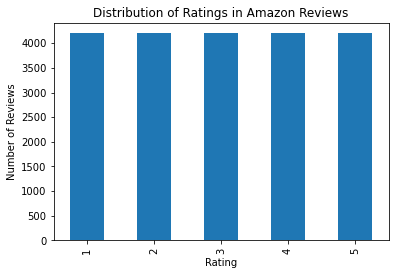

In [11]:
# number of reviews per rating score
df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings in Amazon Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

At first glance, the reviews seem to be evenly distributed.

In [12]:
print('Number of duplicates: ', df.duplicated().sum())
print('Percentage of Duplicates: ', df.duplicated().sum()/df.shape[0])

Number of duplicates:  14509
Percentage of Duplicates:  0.6909047619047619


Almost 70% of the dataset consists of duplicates. A potential reasoning for the high amount of duplicates could be to artificially balance the number of reviews for each rating. 

In [13]:
#An example of duplicates
duplicated_rows = df[df.duplicated(keep=False)]
print(duplicated_rows.sort_values(by='review').head(20))

                                                  review  rating
7794   "High Volume" cartridges...what a joke. With t...       2
8308   "High Volume" cartridges...what a joke. With t...       2
4545   "High Volume" cartridges...what a joke. With t...       2
8314   "High Volume" cartridges...what a joke. With t...       2
4370   "High Volume" cartridges...what a joke. With t...       2
4882   "High Volume" cartridges...what a joke. With t...       2
4361   "High Volume" cartridges...what a joke. With t...       2
7448   "High Volume" cartridges...what a joke. With t...       2
5064   "High Volume" cartridges...what a joke. With t...       2
7971   "High Volume" cartridges...what a joke. With t...       2
16492  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16485  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16361  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
15961  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
15958  "Kurdene S8 Deep B

# EDA & Preprocessing

### Dropping Duplicates / NA

In [14]:
#Drop duplicates, drop NA
clean_df = df.drop_duplicates()
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

/var/folders/16/ydxrn4_n1rnf71rtdjf20l300000gn/T/ipykernel_76760/3968895453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.dropna(inplace=True)


In [15]:
clean_df.head()

,review,rating
0,Does not lay flat. Cord barely fits in channel...,1
1,Only had it for 5 months and it doesn’t work n...,1
2,This is advertised to contain more than 26' of...,1
3,This was supposed to be a gift to me from my w...,1
4,The item arrived with wear and tear. I tried t...,1


In [16]:
# ~6500 rows of data
clean_df.shape

(6491, 2)

The clean dataset is notably smaller and doesn't maintain the same balance as before. However, every category is still reasonably represented.

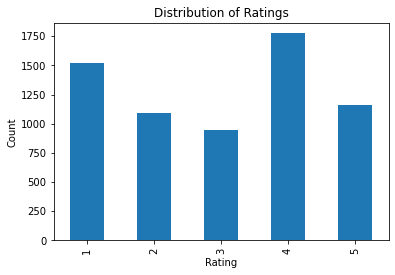

In [17]:
# distribution of clean dataset
clean_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

In [18]:
#display full content of reviews
pd.set_option('display.max_colwidth', None)

# getting 2 samples from each rating score
for rating in range(1, 6):
    sample = clean_df[clean_df['rating'] == rating].sample(2)
    print(sample)
    print('-'*80)  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         review  \
395                                                                                                                                                                                                                                                                  

### Filter only English reviews 

In [19]:
from langdetect import detect, DetectorFactory

# Use random seed for reproducability
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Return True if EN else flase
        return detect(text) == 'en' # True
    except:
        return False

In [20]:
# Filter df English reviews only
df_english_only = clean_df[clean_df['review'].apply(is_english)]

In [21]:
# number of non-english samples
print('Number of non-English samples: ', clean_df.shape[0] - df_english_only.shape[0])

Number of non-English samples:  135


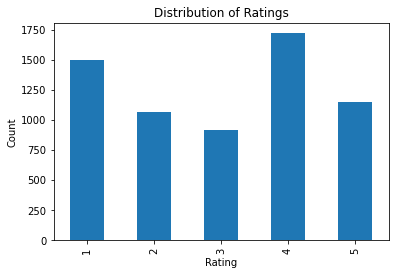

In [22]:
# distribution of clean dataset
df_english_only['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

### Sentiment Visualization 

Textblob assigns a poliarity score to each review which aims to gauge the sentiment.

In [23]:
def get_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

In [24]:
eda_df_binary = df_english_only.copy()
eda_df = df_english_only.copy()

eda_df['sentiment'] = eda_df['review'].apply(get_sentiment)
eda_df_binary['sentiment'] = eda_df_binary['review'].apply(get_sentiment)

#Apply positive(1) is 4 or 5, neg is 1 or 2(0)
eda_df_binary['rating'] = eda_df_binary['rating'].apply(lambda x: 1 if x > 3 else 0)

In [25]:
eda_df.shape

(6356, 3)

Here, as expected the mean of the sentiment score rises throughout each rating. Notably though there is quite a bit of variance which will potentially be difficult for a model to distinguish sentiment through different classes. In the binary case (negative vs. positive) there is also a small difference in sentiment in the positive reviews.

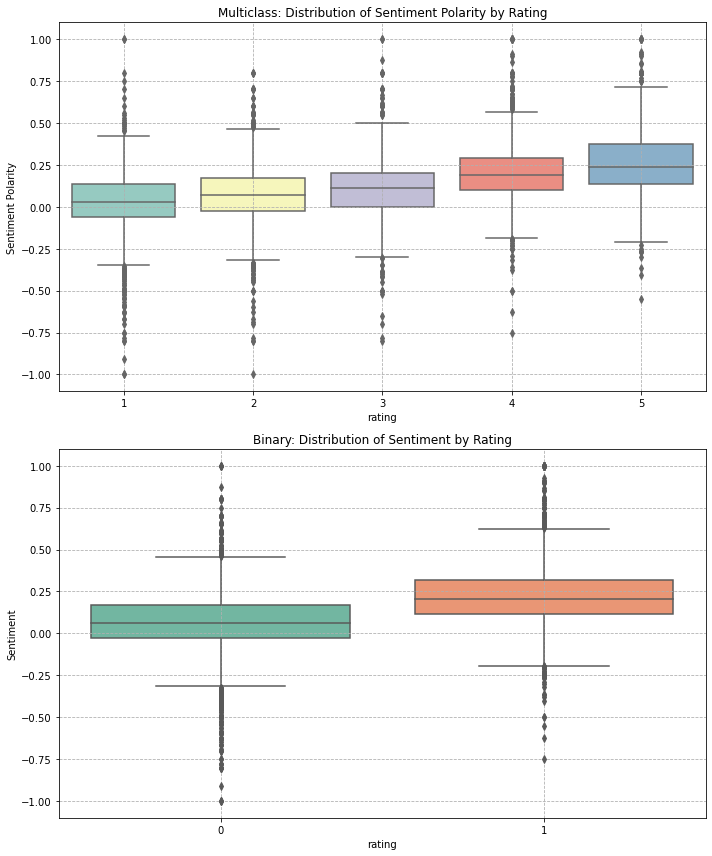

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

#all 5 sentiment values
sns.boxplot(x=eda_df['rating'], y=eda_df['sentiment'], palette="Set3", ax=axes[0])
axes[0].set_title('Multiclass: Distribution of Sentiment Polarity by Rating')
axes[0].grid(True, which='both', linestyle='--')
axes[0].set_ylabel('Sentiment Polarity')

#binary sentiment
sns.boxplot(x=eda_df_binary['rating'], y=eda_df_binary['sentiment'], palette="Set2", ax=axes[1])
axes[1].set_title('Binary: Distribution of Sentiment by Rating')
axes[1].grid(True, which='both', linestyle='--')
axes[1].set_ylabel('Sentiment')

plt.tight_layout()
plt.show()

Below shows the relationship between sentiment and binary rating. The rating is not as strong as one would anticipate.

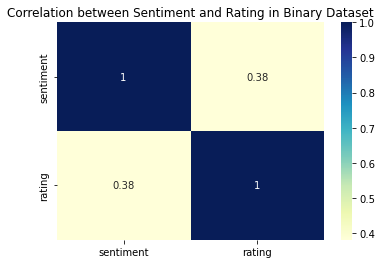

In [27]:
sns.heatmap(eda_df_binary[['sentiment', 'rating']].corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation between Sentiment and Rating in Binary Dataset')
plt.show()

In the binary classification task, the classes are fairly balanced.

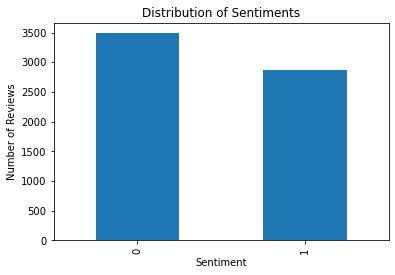

In [28]:
#plot binary distribution. 1 is positive, 0 is negative. 
eda_df_binary['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Common Words 

Below we will look at some of the most common words for both positive and negative reviews. We will use CountVectorizer, which effectively turns the reviews into a matrix of token counts, with one token for each word. We are simply inspecting the raw counts of words (without stopwords, or common words. i.e. the, and, it, etc.).

In [29]:
#seperating out pos and neg reviews
positive_reviews =eda_df_binary[eda_df_binary['rating'] == 1]['review']
negative_reviews = eda_df_binary[eda_df_binary['rating'] == 0]['review']

In [30]:
positive_reviews

3554                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiate count vectorizer with english stop words
countvec_pos = CountVectorizer(stop_words='english')
countvec_neg = CountVectorizer(stop_words='english')

#vectorize both pos and neg reviews
pos = countvec_pos.fit_transform(positive_reviews)
neg = countvec_neg.fit_transform(negative_reviews)

In [32]:
# create 2 df for each positive and negative words
pos_word_counts = pd.DataFrame(
    {"counts": pos.toarray().sum(axis=0)},
    index=countvec_pos.get_feature_names_out()
).sort_values("counts", ascending=False)

neg_word_counts = pd.DataFrame(
    {"counts": neg.toarray().sum(axis=0)},
    index=countvec_neg.get_feature_names_out()
).sort_values("counts", ascending=False)

Some quick observations: 
- `Just` is in the top 3 for both positive and negative. This makes sense as it is commonly used. 
- Lots of words appear frequently in both, some examples: `Great`, `Quality`, `Good`. My theory is `not` is perhaps a stopword and we are only looking at single words, not n-grams or strings of words. i.e. `NOT Good Quality!` 


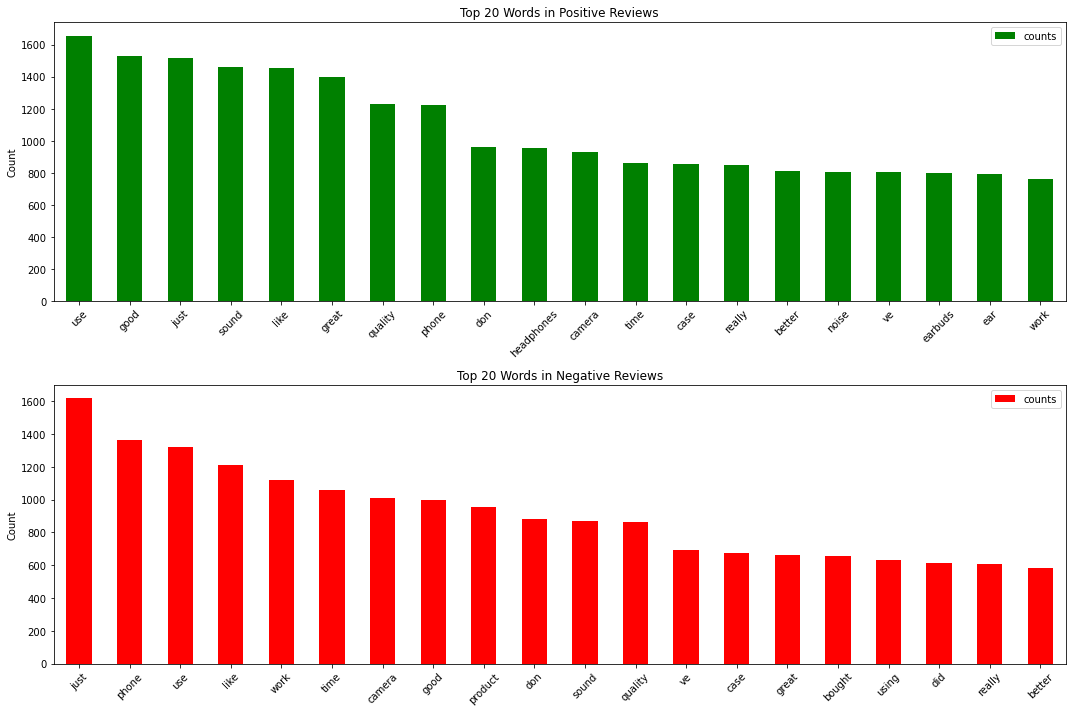

In [33]:
# Plotting for Positive Reviews
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
pos_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Top 20 Words in Positive Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plotting for Negative Reviews
plt.subplot(2, 1, 2)
neg_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='red')
plt.title('Top 20 Words in Negative Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Word Vectorization 

Next we are going to see if we can cluster the reviews in 2-dimensional space to see if there is any natural spacing. To do this, it requires vectorizing each word, or token of a review with `Word2Vec`. This effectively turns each word into a multi-dimensional representation, such that words with similar meanings are used in similar contexts are closer in this multi-dimensional space. `Word2Vec` has been trained on massive amounts of text and has a good understanding of semantic relationships between words.

In [34]:
# first split the reviews into words, or tokens
tokenized_df = df_english_only.copy()
tokenized_df['tokenized_reviews'] = tokenized_df['review'].apply(lambda x: x.split())
sentences = tokenized_df['tokenized_reviews'].tolist()

In [35]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews
1145,"Unfortunately the charger does working for Apple car play, better spend the cheaper option, buying magnet only and connect the phone using the old way",1,"[Unfortunately, the, charger, does, working, for, Apple, car, play,, better, spend, the, cheaper, option,, buying, magnet, only, and, connect, the, phone, using, the, old, way]"


In [36]:
# Train Word2Vec
model = Word2Vec(sentences=tokenized_df['tokenized_reviews'], vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_df['tokenized_reviews'], total_examples=model.corpus_count, epochs=10)

(6475664, 8344800)

Here is an example of `Word2Vec` successfully finding similar words within the trained vocabulary of the reviews. Next to each output word is the similiarity score. 

In [37]:
model.wv.most_similar('good', topn=10)

[('decent', 0.8186954259872437),
 ('great', 0.8178064823150635),
 ('bad', 0.7023258805274963),
 ('cheap', 0.6722568869590759),
 ('reasonable', 0.6507339477539062),
 ('good,', 0.6364598870277405),
 ('solid', 0.6312741041183472),
 ('cool', 0.626392126083374),
 ('nice', 0.6250174045562744),
 ('ok', 0.6241027116775513)]

In [38]:
def get_review_vector(review, model):
    # Initialize a list to store vectors
    vectors = []
    for word in review:
        try:
            vectors.append(model.wv[word])
        except KeyError:  # Word not in the model's vocabulary
            pass
    # Average the vectors for each review
    return np.mean(vectors, axis=0)

tokenized_df['review_vector'] = tokenized_df['tokenized_reviews'].apply(lambda x: get_review_vector(x, model))

In [39]:
from sklearn.manifold import TSNE

#Turn into array so TSNE can take
vectors = np.array(tokenized_df['review_vector'].tolist())


#TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Add to DataFrame for ease of use
tokenized_df['tsne_x'] = reduced_vectors[:, 0] 
tokenized_df['tsne_y'] = reduced_vectors[:, 1]

/Users/jacquelineduong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jacquelineduong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


With the current embeddings, it appears that the data is not easily seperable. Below shows a very dense cluster. This could be due to:
- Overlap in semantic content. 
- The embeddings may not capture detailed meanings
- Inherent complexity of the way people write reviews and then subsequently give their scores.

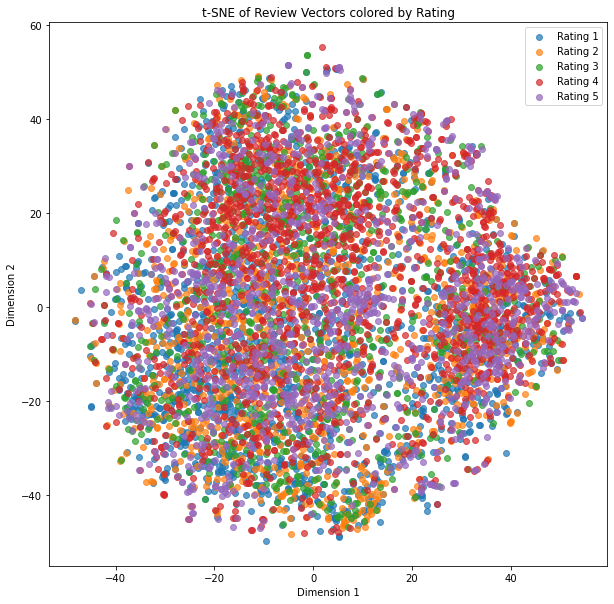

In [40]:
plt.figure(figsize=(10, 10))
for rating in tokenized_df['rating'].unique():
    subset = tokenized_df[tokenized_df['rating'] == rating]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], label=f'Rating {rating}', alpha=0.7)

plt.legend()
plt.title('t-SNE of Review Vectors colored by Rating')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Good, Neutral, Bad

Now we try extending our classification to three classes, where scores of 1/2 = Bad, 3 = Neutral, 4/5 = Good

In [41]:
#Here we extend our classification to three classes, where scores of 1 & 2 return Bad, score = 3 returns Neutral, 
#scores 4 & 5 return good
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

In [42]:
#Creating a new column with the new rating applied
tokenized_df['good/neutral/bad'] = tokenized_df['rating'].apply(rating)

In [43]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad
5930,"I guess I am lucky and got a true and good SanDisk memory card. No issues whatsoever. I was a little worried reading the reviews denouncing the fake SanDisk memory cards and issues but so far, this is the real deal.",5,"[I, guess, I, am, lucky, and, got, a, true, and, good, SanDisk, memory, card., No, issues, whatsoever., I, was, a, little, worried, reading, the, reviews, denouncing, the, fake, SanDisk, memory, cards, and, issues, but, so, far,, this, is, the, real, deal.]","[-0.124716885, 0.28687572, 0.049358338, -0.54459137, 0.11679108, -0.5068517, 0.1869677, 0.8572518, -0.6902289, 0.015188717, -0.32299015, -0.27776766, -0.35847163, 0.13735549, 0.037505854, -0.44514883, 0.52647585, 0.7212104, -0.0453159, -0.098745435, 0.69091636, 0.25758314, 0.20924982, -0.077814534, -0.58688533, -0.06682053, 0.355053, -0.12069696, -0.015089087, -0.11058783, 0.03216499, 0.31843084, 0.38305643, -0.37864348, -0.09217237, 0.71079844, 0.20520425, 0.41766664, -0.058053926, 0.076126695, 0.10303066, -0.17384972, 0.23813769, 0.61546546, 0.24686627, 0.20340747, -0.12818222, -0.031347506, 0.20300546, -0.16981526, -0.429003, -0.32973108, -0.24974018, -0.505299, 0.07005111, 0.22633897, 0.8432115, -1.065433, 0.06861488, -0.1258993, 0.104270734, 0.11763181, 0.1889312, -0.49794048, 0.0070439056, 0.18916641, 0.2260287, 0.49824208, -0.5100424, 0.14819908, -0.4219892, 0.024008736, 1.0290538, 0.03289144, -0.06034319, 1.0514855, 0.16391657, 0.41690388, -0.7415529, -0.28880802, 0.03517091, -0.030010395, -0.10043461, 0.46377432, 0.51232857, -0.85951644, -0.25683185, 1.0897087, 0.15270168, 0.008867924, -0.55658793, 0.50200343, 0.52881426, 0.5095667, 0.6196075, 0.2562777, 0.48909155, 0.13713431, 0.35913426, -0.05550277]",-28.293484,-14.822786,Good


### Sorting Number of Words By Category

We can calculate the number of words in each review and visualize the distribution of number of words against category

In [44]:
#calculate number of words in each review
sent_len = []
for sent in tokenized_df['review']:
    sent_len.append(len(word_tokenize(sent)))
tokenized_df['sent_len'] = sent_len
tokenized_df.head()

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad,sent_len
0,Does not lay flat. Cord barely fits in channel and it is not tapered to prevent someone from catching their foot. Does not look like the sample pictures. Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through. Don’t waste your money.,1,"[Does, not, lay, flat., Cord, barely, fits, in, channel, and, it, is, not, tapered, to, prevent, someone, from, catching, their, foot., Does, not, look, like, the, sample, pictures., Perhaps, makes, the, cord, a, bigger, trip, hazard, as, it, does, not, lay, flat, no, matter, how, you, push, it, down, or, pull, the, cord, through., Don’t, waste, your, money.]","[0.032559942, -0.03924909, -0.6531411, -0.39903682, 0.0026290375, -0.6017092, 0.23785603, 0.94393647, -0.7111382, -0.6257044, -0.5568201, 0.14776725, -0.6446529, 0.23100139, -0.08630409, 0.38458657, 0.23633525, 0.28018728, 0.26563877, -0.15472302, 0.35350096, 0.31234017, 0.4430028, -0.068507835, 0.1827609, -0.39849904, -0.45341128, 0.34540507, 0.32998538, -0.02391934, 0.33486214, 0.3639532, 0.007972586, -0.63690746, -0.055027287, 0.4566593, 0.47954738, 0.6189207, -0.19640031, -0.502824, -0.015843833, -0.356467, 0.20420721, -0.07059343, 0.15538037, -0.43202713, -0.337448, 0.03854314, 0.746204, 0.2560139, -0.35064024, -0.4385739, -0.044730943, 0.05372255, 0.5355874, 0.63642716, 0.14408109, -0.38954374, 0.24891771, 0.44795215, 0.52728754, 0.31873748, 0.2851155, -0.0805754, -0.51758343, 0.15273026, 0.009312755, -0.17071734, -0.14983146, -0.04686206, -0.21614969, 0.104379825, 1.0767198, 0.29780358, -0.10316262, 0.6000968, 0.035697356, 0.2847704, -0.48697716, -0.1828557, 0.0141869215, 0.28800485, 0.08902955, 0.48912147, -0.00866822, -0.28802884, 0.00156121, 1.0893499, 0.26483443, -0.07369863, 0.4976539, 0.17836751, 0.32350728, 0.2474048, 0.45772, 0.23075983, -0.39026013, -0.6707645, 0.2902049, -0.06731398]",-5.310270,40.746681,Bad,65
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u..,1,"[Only, had, it, for, 5, months, and, it, doesn’t, work, now, at, all, nd, this, is, my, second, pair, within, the, first, week, had, to, get, a, replacement, caz, the, sound, was, so, low, u, couldn’t, hear, nothing, nd, no, it’s, sound, but, no, one, can, hear, u..]","[-0.022207074, -0.13110127, -0.22900505, -0.44061852, -0.08985358, -0.62762994, 0.50554806, 0.88566786, -0.78255874, 0.47240826, -0.3149069, 0.110922, -0.5024215, 0.30201188, 0.10326344, -0.08979425, -0.11444378, 0.27843016, -0.5338933, 0.2701623, 0.31985193, 0.31318033, 0.4697055, 0.44237295, -0.54234785, -0.6308256, -0.23357053, -0.5039246, 0.4000965, -0.116599105, -0.36068165, -0.044164192, 0.60528404, -0.33059132, -0.19934922, 0.5643298, -0.08349439, 0.6515763, -0.25276685, -0.56100637, -0.23140739, 0.046458766, 0.0767097, 0.61355656, 0.6355862, -0.023581417, -0.07511818, 0.063160546, 0.98635584, -0.19447571, -0.80170316, -0.7834763, -0.13497551, -0.7175304, 0.78344864, -0.051623236, 0.6118032, -1.2417177, 0.3232531, -0.31372306, 0.048188325, 0.023072436, 0.38780832, -0.47339132, -0.5116292, 0.3617356, -0.32905152, 0.8089967, -0.36943746, -0.07152324, -0.40410534, 0.24083887, 0.5347445, 0.15132147, -0.34727752, 1.1369774, 0.08285171, -0.080114834, -0.69989544, 0.16132678, 0.49235347, -0.4251906, -0.21873866, 0.022972563, 0.14056398, -0.63814026, -0.42105544, 1.2801069, 0.16081382, 0.06235349, -0.0142914755, 0.3524438, 0.63210464, 0.01330211, 1.3044165, 0.55523473, -0.28569415, -0.33925924, 0.4836785, -0.42381752]",-12.616052,-43.401169,Bad,55
2,"This is advertised to contain more than 26' of tape. I purchased two, installed one and immediately printed 10-15 identical 5” labels (to add to some I had printed when my previous tape ran out). To my shock, the new tape ran out

Now we can visualize the average number of words per category

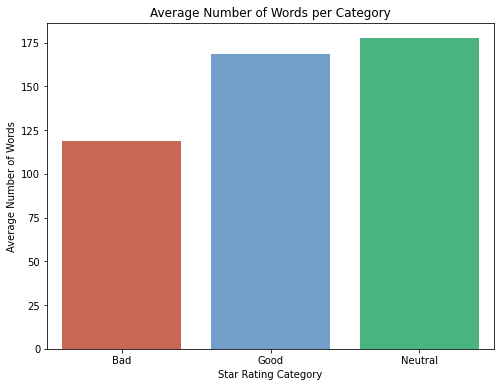

In [45]:
colors = ['#DE5A3F', '#62A2D9', '#38C682']
sns.set_palette(colors)
average_words_per_category = tokenized_df.groupby('good/neutral/bad')['sent_len'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=average_words_per_category.index, y=average_words_per_category.values)
plt.title("Average Number of Words per Category")
plt.xlabel("Star Rating Category")
plt.ylabel("Average Number of Words")
plt.show()

In [46]:
print(tokenized_df.groupby('rating').count())

        review  tokenized_reviews  review_vector  tsne_x  tsne_y  \
rating                                                             
1         1496               1496           1496    1496    1496   
2         1071               1071           1071    1071    1071   
3          920                920            920     920     920   
4         1721               1721           1721    1721    1721   
5         1148               1148           1148    1148    1148   

        good/neutral/bad  sent_len  
rating                              
1                   1496      1496  
2                   1071      1071  
3                    920       920  
4                   1721      1721  
5                   1148      1148  


### Lowercase Conversion, Punctuation Removal, Stopword Removal, Lemmatization 

 We can finish our preprocessing with lowercase conversion, removing punctuation, tokenizing, stopword removal and lemmatization

In [47]:
# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacquelineduong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [49]:
# Preprocess and replace paragraphs in the dataset
for idx, row in tokenized_df.iterrows():
    paragraph = row['review']

    # Convert to lowercase
    paragraph = paragraph.lower()

    # Remove punctuation
    paragraph = paragraph.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    words = word_tokenize(paragraph)

    # Remove stop words and lemmatize
    filtered_words = []
    for word in words:
        if word not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word)
            filtered_words.append(lemmatized_word)

    preprocessed_paragraph = ' '.join(filtered_words)

    # Update the dataset with the preprocessed paragraph
    tokenized_df.at[idx, 'review'] = preprocessed_paragraph

In [50]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad,sent_len
5028,easy assemble use app come work pretty well issue camera iphone 13 max lining phone mount use old phone still worksthe biggest problem ive found lock slipping trying line something ive found need line star fov fall back place engage lock im sure common telescope first one ive owned ever used one schooloverall im happy purchase likely need look new solution mount tripod part,4,"[It, was, very, easy, to, assemble, and, use., the, app, that, it, comes, with, works, pretty, well, but, I, did, have, an, issue, with, the, cameras, on, my, iphone, 13, max, not, lining, up, with, the, phone, mount, so, i, have, to, use, an, old, phone, but, it, still, works.The, other, biggest, problem, ive, found, is, the, locks, slipping, when, trying, to, line, something, up,, ive, found, i, need, to, line, the, star, up, below, my, FOV, just, for, it, to, fall, back, down, into, place, when, I, engage, the, lock., Im, not, sure, how, common, this, is, with, telescopes, ...]","[-0.13704444, -0.2270446, -0.58737427, -0.78856987, 0.03338278, -0.9696847, 0.15313923, 0.960769, -0.8206718, -0.0138924075, -0.21406977, 0.29906067, -0.7809668, 0.10462029, 0.17098698, -0.11670789, 0.38567558, 0.23075491, -0.45079824, -0.08817005, 0.55678016, 0.3771875, 0.72660714, 0.21189584, 0.06451503, -0.13946119, -0.27852684, 0.0667414, 0.47723344, 0.11956834, 0.046830613, 0.15521091, 0.6820209, -0.44140464, 0.124063864, 0.7403143, 0.7037119, 0.8397672, -0.43473303, -0.31418654, -0.29594323, 0.19488373, 0.16450779, 0.57892466, 0.09917166, -0.40444615, 0.010956754, 0.28629658, 0.5375449, 0.16513376, -0.6555812, -0.64282453, -0.033528827, -0.13089813, 0.49411938, 0.10109592, 0.37791613, -0.8591504, 0.11224134, -0.04904, 0.4013398, 0.26304096, 0.3690975, -0.17078644, -0.2919728, 0.22954544, 0.19699445, 0.5459792, -0.17651314, 0.10371016, -0.44749954, 0.13130048, 0.9398594, -0.0981621, -0.7004984, 1.0378923, -0.028010102, -0.08217313, -1.080895, -0.48388836, 0.2819517, 0.105785996, -0.039839365, 0.38350675, 0.20225877, -0.3121598, -0.21979074, 1.300274, 0.18421014, 0.20371734, -0.08672486, 0.5685727, 0.4485465, 0.68081075, 0.7622471, 0.38169193, 0.004864105, -0.30407003, 0.29807544, -0.12596677]",0.288514,-17.193987,Good,143


# Modeling

In [51]:
#Create a separate binary rating column to be used in binary classification
tokenized_df['binaryrating'] = tokenized_df['rating'].apply(lambda x: 1 if x > 3 else 0)

In [52]:
data_prepped = tokenized_df.copy()

### Train-Test Split + Vectorization

In [53]:
X = data_prepped.copy()
y = data_prepped['rating'].copy()
y_binary = data_prepped['binaryrating'].copy()

In [54]:
#Multinomial Case
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.1, random_state=42)

#Binary Case
binary_train_data, binary_test_data, binary_train_labels, binary_test_labels = train_test_split(X, y_binary, test_size=0.1, random_state=42)

In [55]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2048, ngram_range=(1, 3))

# Vectorize the training set
train_data_tfidf = vectorizer.fit_transform(train_data['review'])

#Transform the test set to make sure we use the same features as the training set
test_data_tfidf = vectorizer.transform(test_data['review'])

# Vectorize Binary training set
binary_train_data_tfidf = vectorizer.fit_transform(binary_train_data['review'])

#Transform the test set to make sure we use the same features as the training set
binary_test_data_tfidf = vectorizer.transform(binary_test_data['review'])

# Convert the TF-IDF vectors to a dense array for better readability
vectors_array = test_data_tfidf.toarray()
vectors_df = pd.DataFrame(vectors_array, columns=vectorizer.get_feature_names_out())

In [56]:
train_data.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad,sent_len,binaryrating
509,set easily battery dead within hour rechargeable came battery already mostly dead ordered 2 result,1,"[Set, up, easily, battery, dead, within, hours,, these, are, not, rechargeable, so, it, came, with, the, battery, already, mostly, dead., I, ordered, 2, and, both, had, the, same, result]","[-0.25237492, -0.09902137, 0.18239143, -0.23161282, 0.059259575, -0.95603895, -0.031624384, 0.9998824, -0.9777764, 0.25572962, -0.73441994, 0.57665336, -0.3620291, 0.23651257, -0.01971133, -0.22659695, 0.5175381, -0.04142734, -0.5218226, 0.029291365, 0.0328172, 0.24336587, 0.8128438, 0.5987927, -0.3507576, -0.4777317, -0.18515807, 0.46105132, 0.29334253, -0.16309224, -0.11220526, -0.019230084, 0.67421967, 0.27035692, -0.21148297, 0.83300793, 0.05168666, -0.03250889, -0.8212497, -0.38354877, -0.42308524, -0.24886733, -0.09069111, 0.5071395, 0.26980367, -0.3389867, -0.2726293, 0.6058392, 0.4119478, -0.3055917, -0.98947704, -0.3561254, -0.1863169, -0.5793555, -0.061170507, 0.33879128, 0.11961968, -0.8180538, -0.33515856, -0.17163768, -0.3917582, -0.5203069, 0.30025136, 0.020625787, 0.056118004, 0.31140292, 0.5673563, 0.7613871, -0.77621615, 0.326204, -0.013343414, 0.33177903, 0.4679123, -0.069188446, -0.60061795, 1.6454568, 0.37586093, -0.28356147, -1.127659, 0.2926436, 0.015728282, -0.26356953, -0.35304108, -0.2913579, -0.09954174, -0.18340443, 0.08465687, 1.3131329, -0.13628988, -0.006777256, -0.08706403, 0.11947305, 0.6076496, 0.45174634, 1.036587, 0.1870998, 0.10256368, -0.46091607, 0.7224214, -0.117622726]",13.927749,-41.635811,Bad,31,0


In [57]:
print(train_data_tfidf.shape)

(5720, 2048)


In [58]:
print(test_data_tfidf.shape)

(636, 2048)


In [59]:
print(train_data_tfidf)

  (0, 235)	0.3432436359944046
  (0, 1498)	0.2992644621892211
  (0, 1989)	0.19678662383390394
  (0, 635)	0.3308175528275678
  (0, 2025)	0.530923494488549
  (0, 1629)	0.5103935293499358
  (0, 1163)	0.3194965534070027
  (1, 732)	0.20210445308372088
  (1, 1897)	0.07790598631854939
  (1, 392)	0.1784178279468799
  (1, 349)	0.14254270095974558
  (1, 1233)	0.13446468732916272
  (1, 632)	0.12674948751025258
  (1, 100)	0.13094302462187649
  (1, 489)	0.1197212505561062
  (1, 1645)	0.14726892793932994
  (1, 793)	0.13260524050613276
  (1, 465)	0.12182947876992195
  (1, 1981)	0.14282866561278926
  (1, 205)	0.102265022788342
  (1, 731)	0.16499344934315863
  (1, 1221)	0.1471058127054246
  (1, 1342)	0.35765417050608667
  (1, 1150)	0.0995297572274705
  (1, 1815)	0.17132098421111766
  :	:
  (5719, 1821)	0.21202149248775112
  (5719, 658)	0.218060362736733
  (5719, 1687)	0.18095908883464729
  (5719, 120)	0.2287959455798918
  (5719, 587)	0.23802411068925322
  (5719, 825)	0.1575176854603807
  (5719, 1940)	0.

In [60]:
print(len(train_data))

5720


In [61]:
print(len(train_labels))

5720


### SMOTE

In [62]:
#smote = SMOTE(sampling_strategy='auto')  # Adjust the sampling strategy

In [63]:
#smote_train_data, smote_train_labels = smote.fit_resample(train_data_tfidf, train_labels)
#smote_binary_train_data, smote_binary_train_labels = smote.fit_resample(binary_train_data, binary_train_labels)

## Binary Classification Models

In [64]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=FutureWarning)

# dictionary of models to run
models = {'Logistic Regression':LogisticRegression(),'KNN':KNeighborsClassifier(),
          'Random Forest':RandomForestClassifier(), 'XGB':GradientBoostingClassifier()}


for model_name, classifier in models.items():
    classifier.fit(binary_train_data_tfidf, binary_train_labels)
    predictions = classifier.predict(binary_test_data_tfidf)
    accuracy = accuracy_score(binary_test_labels,predictions)
    
    print(f"Model: {model_name}")
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(binary_test_labels, predictions))

Model: Logistic Regression
Accuracy: 0.789308176100629
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       355
           1       0.79      0.72      0.75       281

    accuracy                           0.79       636
   macro avg       0.79      0.78      0.78       636
weighted avg       0.79      0.79      0.79       636

Model: KNN
Accuracy: 0.6808176100628931
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       355
           1       0.69      0.50      0.58       281

    accuracy                           0.68       636
   macro avg       0.68      0.66      0.66       636
weighted avg       0.68      0.68      0.67       636

Model: Random Forest
Accuracy: 0.7877358490566038
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       355
           1       0.76

## Multinomial Classification Models

### SMOTE

In [65]:
smote = SMOTE(sampling_strategy='auto')  # Adjust the sampling strategy

In [66]:
smote_train_data, smote_train_labels = smote.fit_resample(train_data_tfidf, train_labels)

### Logistic Regression Model

In [67]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(smote_train_data, smote_train_labels)

# Make predictions on the test set
lr_predictions = logreg_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, lr_predictions))

              precision    recall  f1-score   support

           1       0.54      0.50      0.52       163
           2       0.30      0.35      0.32       105
           3       0.27      0.29      0.28        87
           4       0.52      0.48      0.50       154
           5       0.60      0.61      0.61       127

    accuracy                           0.46       636
   macro avg       0.45      0.45      0.45       636
weighted avg       0.47      0.46      0.47       636



/Users/jacquelineduong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Model

In [68]:
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=69, random_state=42)

# Train the Random Forest model
random_forest_model.fit(smote_train_data, smote_train_labels)

# Make predictions on the test set using Random Forest
rf_predictions = random_forest_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, rf_predictions))

              precision    recall  f1-score   support

           1       0.55      0.63      0.59       163
           2       0.33      0.25      0.28       105
           3       0.22      0.15      0.18        87
           4       0.44      0.57      0.50       154
           5       0.54      0.46      0.50       127

    accuracy                           0.45       636
   macro avg       0.41      0.41      0.41       636
weighted avg       0.44      0.45      0.44       636



<Figure size 7200x7200 with 0 Axes>

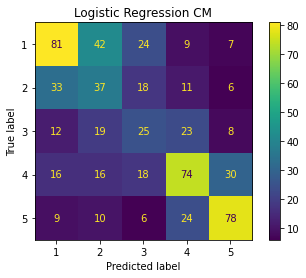

In [69]:
plt.figure(figsize = (100,100))
cm = sklearn.metrics.confusion_matrix(test_labels, lr_predictions, labels = logreg_model.classes_)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logreg_model.classes_)
cm_display.plot()
plt.title("Logistic Regression CM")
plt.show()

In [70]:
feature_importance = pd.DataFrame({'Feature': vectors_df.columns, 'Importance': random_forest_model.feature_importances_})

# Sort feature importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(25))

         Feature  Importance
769        great    0.011425
539         easy    0.008128
1989        work    0.007470
754         good    0.007307
276       camera    0.006710
1033        love    0.006533
1200         one    0.006093
1897         use    0.005962
1490      return    0.005332
1115       month    0.005065
2011       would    0.004824
731          get    0.004682
990         like    0.004643
1397     quality    0.004565
1275       phone    0.004503
1370     product    0.004427
1955        well    0.004331
1266     perfect    0.004231
1352       price    0.004065
1992  work great    0.004046
1113       money    0.003998
269        cable    0.003931
570         even    0.003895
1815        time    0.003811
1937       waste    0.003697


### Gradient Boosting Model

In [71]:
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

#train the Gradient Boosting model
gbm_model.fit(smote_train_data, smote_train_labels)

#make predictions
gbm_predictions = gbm_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, gbm_predictions))

              precision    recall  f1-score   support

           1       0.54      0.50      0.52       163
           2       0.29      0.31      0.30       105
           3       0.26      0.25      0.25        87
           4       0.43      0.43      0.43       154
           5       0.50      0.52      0.51       127

    accuracy                           0.42       636
   macro avg       0.40      0.40      0.40       636
weighted avg       0.43      0.42      0.42       636



### Multinomial Naive Bayes Model

In [72]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

#train the Multinomial Naive Bayes model
nb_model.fit(smote_train_data, smote_train_labels)

#make predictions
nb_predictions = nb_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, nb_predictions))

              precision    recall  f1-score   support

           1       0.56      0.56      0.56       163
           2       0.31      0.32      0.31       105
           3       0.32      0.29      0.30        87
           4       0.51      0.53      0.52       154
           5       0.59      0.57      0.58       127

    accuracy                           0.48       636
   macro avg       0.46      0.46      0.46       636
weighted avg       0.48      0.48      0.48       636



### Multilayer Perceptron

In [73]:
#create the MLPClassifier with chosen hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

#train the MLP model on the training data
mlp_classifier.fit(train_data_tfidf, train_labels)

#use the trained model to make predictions
y_pred = mlp_classifier.predict(test_data_tfidf)

#evaluate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.39


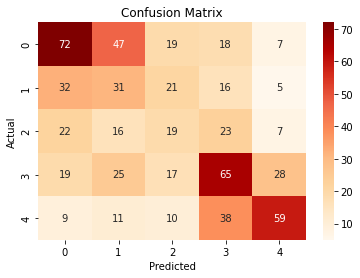

In [74]:
#confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(test_labels, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [75]:
#MLP Classification Report
classification_report = metrics.classification_report(test_labels, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

           1       0.47      0.44      0.45       163
           2       0.24      0.30      0.26       105
           3       0.22      0.22      0.22        87
           4       0.41      0.42      0.41       154
           5       0.56      0.46      0.51       127

    accuracy                           0.39       636
   macro avg       0.38      0.37      0.37       636
weighted avg       0.40      0.39      0.39       636

